In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('../data/month_energy_dataset.csv')
df

,year,month,val_geracao
0,2006,3,9.710000e+00
1,2006,4,3.441800e+02
2,2006,5,1.724670e+03
3,2006,6,8.398590e+03
4,2006,7,1.796663e+04
...,...,...,...
215,2024,2,6.339385e+06
216,2024,3,5.302218e+06
217,2024,4,6.003793e+06
218,2024,5,8.899730e+06


In [3]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('date', inplace=True)
df

,year,month,val_geracao
date,,,
2006-03-01,2006,3,9.710000e+00
2006-04-01,2006,4,3.441800e+02
2006-05-01,2006,5,1.724670e+03
2006-06-01,2006,6,8.398590e+03
2006-07-01,2006,7,1.796663e+04
...,...,...,...
2024-02-01,2024,2,6.339385e+06
2024-03-01,2024,3,5.302218e+06
2024-04-01,2024,4,6.003793e+06


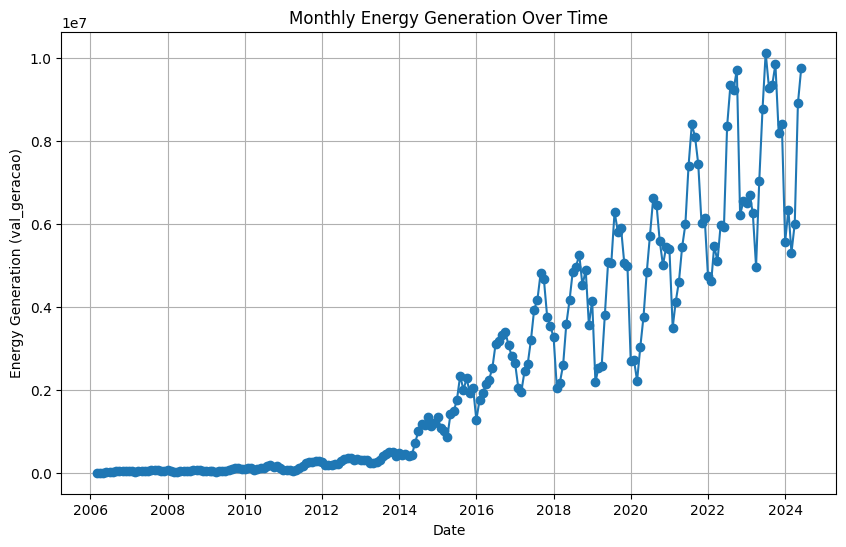

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['val_geracao'], marker='o')
plt.title('Monthly Energy Generation Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Generation (val_geracao)')
plt.grid(True)
plt.show()

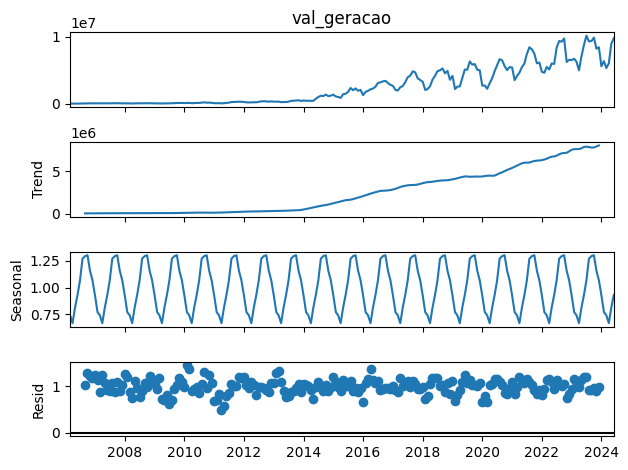

In [5]:
decomp_energy = seasonal_decompose(df['val_geracao'], model='multiplicative', period=12)
decomp_energy.plot()
plt.show()

In [6]:
# Função para realizar o teste de Dickey-Fuller Aumentado
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Realizar o teste de Dickey-Fuller Aumentado
adf_test(df['val_geracao'])

ADF Statistic: 2.3357805277348733
p-value: 0.9989768076916985
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


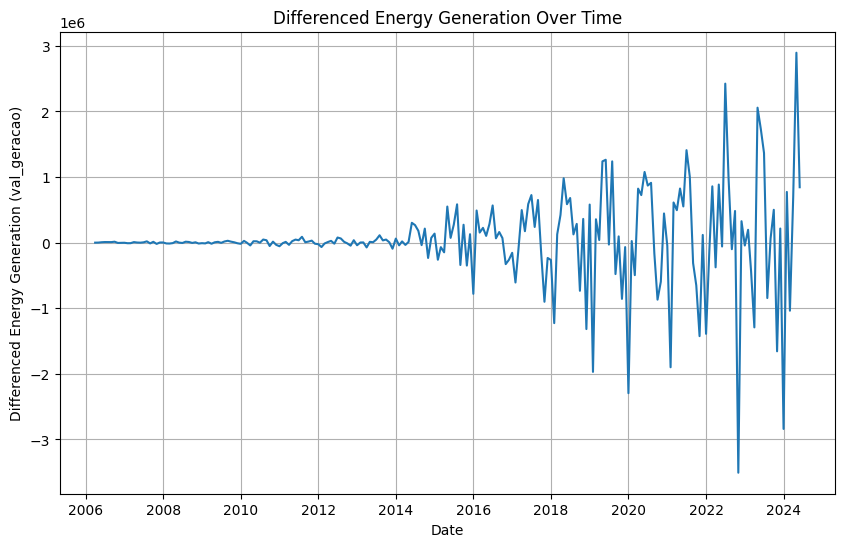

In [7]:
# Diferenciação da série temporal
df['val_geracao_diff'] = df['val_geracao'].diff().dropna()

# Plotar a série diferenciada
plt.figure(figsize=(10, 6))
plt.plot(df['val_geracao_diff'])
plt.title('Differenced Energy Generation Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Energy Generation (val_geracao)')
plt.grid(True)
plt.show()

In [8]:
# Realizar o teste de Dickey-Fuller Aumentado na série diferenciada
adf_test(df['val_geracao_diff'].dropna())

ADF Statistic: -2.6545762562885526
p-value: 0.08223373305243153
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


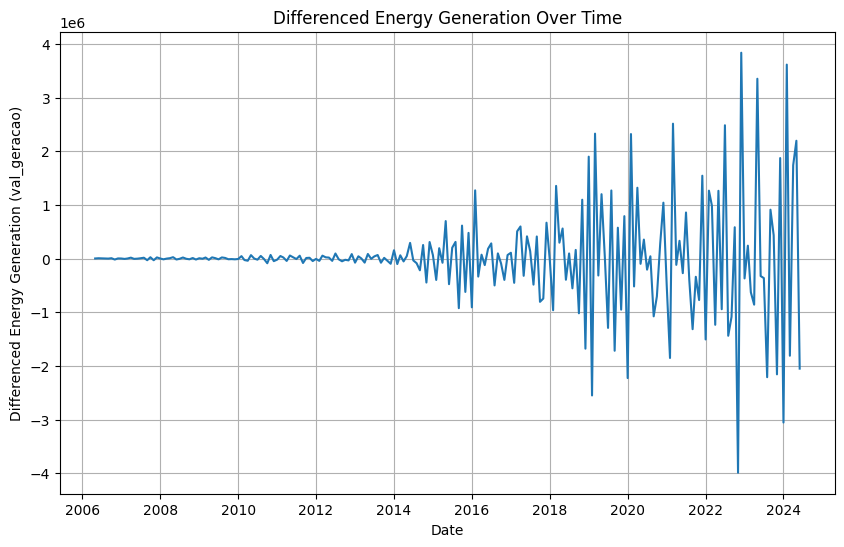

In [9]:
# Diferenciação da série temporal
df['val_geracao_diff_2'] = df['val_geracao_diff'].diff().dropna()

# Plotar a série diferenciada
plt.figure(figsize=(10, 6))
plt.plot(df['val_geracao_diff_2'])
plt.title('Differenced Energy Generation Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Energy Generation (val_geracao)')
plt.grid(True)
plt.show()

In [10]:
# Realizar o teste de Dickey-Fuller Aumentado na série diferenciada
adf_test(df['val_geracao_diff_2'].dropna())

ADF Statistic: -10.534185537225605
p-value: 8.989577121340786e-19
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


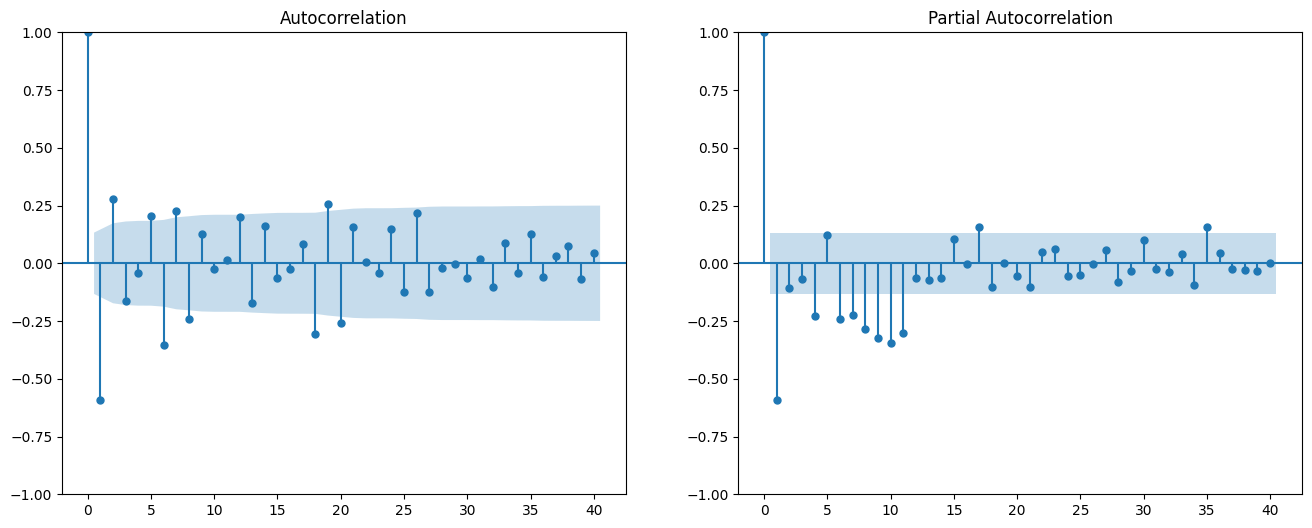

In [11]:
# Plotar ACF e PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(df['val_geracao_diff_2'].dropna(), lags=40, ax=axes[0])
plot_pacf(df['val_geracao_diff_2'].dropna(), lags=40, ax=axes[1])

plt.show()

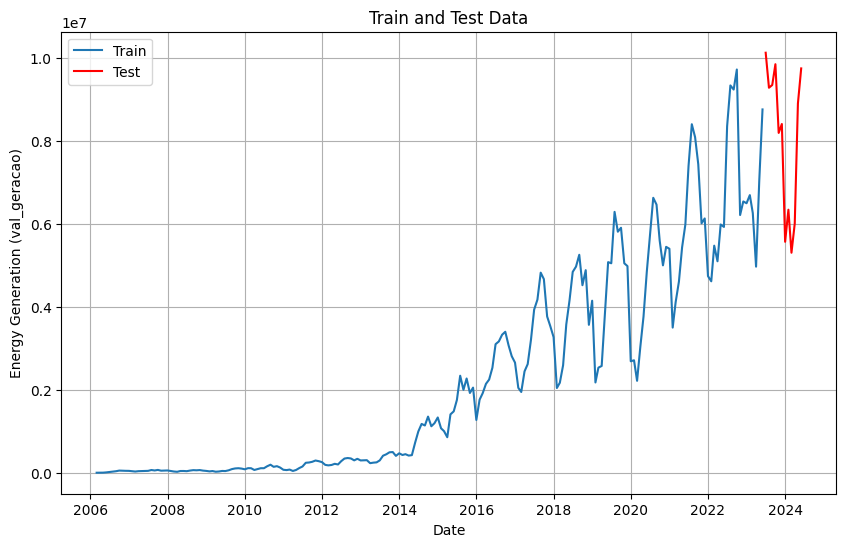

In [12]:
train_size = int(len(df) * 208 / 220)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Plotar os conjuntos de treino e teste
plt.figure(figsize=(10, 6))
plt.plot(train['val_geracao'], label='Train')
plt.plot(test['val_geracao'], label='Test', color='red')
plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('Energy Generation (val_geracao)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Ajustar o modelo SARIMA nos dados de treino
model = SARIMAX(train['val_geracao'], order=(1, 2, 1), seasonal_order=(2, 1, 0, 12))
model_fit = model.fit(disp=False)

# Exibir o resumo do modelo
print(model_fit.summary())

e:\Anaconda\envs\energy_env_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Anaconda\envs\energy_env_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         val_geracao   No. Observations:                  208
Model:             SARIMAX(1, 2, 1)x(2, 1, [], 12)   Log Likelihood               -2828.667
Date:                             Sat, 13 Jul 2024   AIC                           5667.335
Time:                                     17:59:33   BIC                           5683.674
Sample:                                 03-01-2006   HQIC                          5673.951
                                      - 06-01-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4105      0.071     -5.799      0.000      -0.549      -0.272
ma.L1         -0.9923      

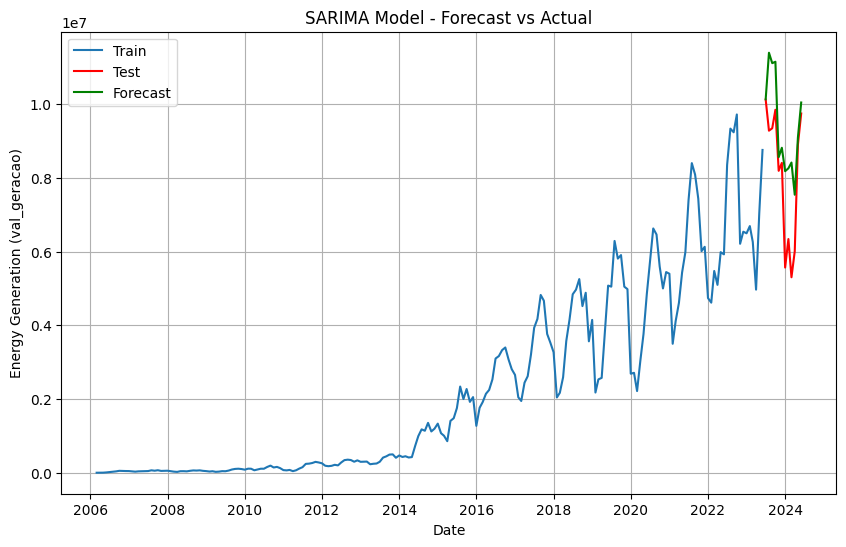

In [14]:
# Fazer previsões no conjunto de teste
pred_start = test.index[0]
pred_end = test.index[-1]
predictions = model_fit.predict(start=pred_start, end=pred_end, dynamic=False)

# Plotar as previsões versus dados reais
plt.figure(figsize=(10, 6))
plt.plot(train['val_geracao'], label='Train')
plt.plot(test['val_geracao'], label='Test', color='red')
plt.plot(predictions, label='Forecast', color='green')
plt.title('SARIMA Model - Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Energy Generation (val_geracao)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Calcular métricas de erro
mae = mean_absolute_error(test['val_geracao'], predictions)
mse = mean_squared_error(test['val_geracao'], predictions)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 1303761.0788945423
Mean Squared Error (MSE): 2690129137448.892
Root Mean Squared Error (RMSE): 1640161.3144593101
